# Wprowadzenie do NLP

Opracowanie: Dominika Wnuk <dwnuk@pja.edu.pl>

Modyikacja: Danijel Koržinek <danijel@pja.edu.pl>


Na tym ćwiczeniu sprawdzimy kilka podstawowych kroków potrzebnych do realizacji prostego zadania analizy tekstu - rozozpawanie wydźwięku. Dane jakie będziemy analizować pochodzą z internetu i przez to mogą być znacznie zanieczyszczone. Etapy jakie mamy wykonać to:

1. pobieranie danych (w przypadku tego ćwiczenia jest to już zrealizowane)
2. etykietowanie danych (to też już posiadamy)
3. czyszczenie i normalizacja tekstu
4. tokenizacja, stemming, lematyzacja
5. ekstrakcja cech
6. klasyfikacja

Zaczynijmy więc od pobrania przygotowanego zbioru danych. Pochodzi on z Twittera i został zapisany w formacie CSV pod adresem:

https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv

In [ ]:
!wget https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv

--2024-03-08 13:05:05--  https://www.pja.edu.pl/~danijel/zum/Sentiment_Data.csv
Resolving www.pja.edu.pl (www.pja.edu.pl)... 91.230.222.123, 2001:67c:23f4:1034::ab03
Connecting to www.pja.edu.pl (www.pja.edu.pl)|91.230.222.123|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://users.pja.edu.pl/~danijel/zum/Sentiment_Data.csv [following]
--2024-03-08 13:05:06--  https://users.pja.edu.pl/~danijel/zum/Sentiment_Data.csv
Resolving users.pja.edu.pl (users.pja.edu.pl)... 91.230.222.21, 2001:67c:23f4::ab00
Connecting to users.pja.edu.pl (users.pja.edu.pl)|91.230.222.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238797239 (228M) [text/csv]
Saving to: ‘Sentiment_Data.csv’

Sentiment_Data.csv  100%[===================>] 227.73M  2.67MB/s    in 22s     

2024-03-08 13:05:29 (10.3 MB/s) - ‘Sentiment_Data.csv’ saved [238797239/238797239]



# Instalacja i import bibliotek

Zacznijmy od zainstalowania najnowszej wersji biblioteki spacy i ściągniecia modelu dla jęyzka angielskiego:

```
!pip install -U spacy
!python -m spacy download en_core_web_md
```


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_md

Następnie zaimportujemy bibliotekę pandas do pracy ze zbiorami danych:
```
import pandas as pd
```

Matplotlib będzie do rysowania wykresów:
```
import matplotlib.pyplot as P
```

Bibliotek seaborn jest rozszerzeniem Matplotlib ułatwiających niektóre obliczenia:
```
import seaborn as sns
```

Spacy to przetwarzania języka:
```
import spacy
```

Moduł Pythonowy do wyrażeń regularnych:
```
import re
```

Wordcloud do rysowania chmur tagów:
```
from wordcloud import WordCloud
```

Progressbary:
```
from tqdm import tqdm
tqdm.pandas()
```

Oraz scikit-learn do klasyfikacji:
```
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
```

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

# Wczytywanie danych

Wczytaj plik CSV metodą `read_csv` z biblioteki pandas podając następujące nazwy kolumn:
```
['target','ids','date','flag','user','text']
```

Po wczytaniu możesz użyc metody `sample` żeby wylosować N wierszy do wyświetlenia.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ZUM/01/Sentiment_Data.csv", names = ['target','ids','date','flag','user','text'])

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.sample(5)

,target,ids,date,flag,user,text
59448,0,1686151192,Sun May 03 04:01:48 PDT 2009,NO_QUERY,blubelles,It's 4:06am and being sick is keeping me awake...
1525611,4,2176896992,Mon Jun 15 05:00:31 PDT 2009,NO_QUERY,canadiancat,Time for lunch - yeah! Leftover chilli and ric...
11729,0,1551490024,Sat Apr 18 09:11:39 PDT 2009,NO_QUERY,nicolexawesome,IT'S SO NICE OUTSIDE! I wish i was in San Dieg...
1179509,4,1981754441,Sun May 31 09:49:27 PDT 2009,NO_QUERY,judiesmail,Beautiful sunny Sunday
1431189,4,2060034584,Sat Jun 06 18:07:49 PDT 2009,NO_QUERY,JessicaR_NY,@BGurl21585 Thanks!! I'm trying not to jinx...


Jaki rozmiar ma wczytana tabela danych?

In [ ]:
df.shape

(1600000, 6)

Użyj metody `info` żeby się więcej dowiedzieć o typach danych i rozmiaru w pamięci.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Metoda `nunique` zlicza ile jest różnych wartości w każdej kolumnie, ale jeśli najpierw użyjemy metody `groupby` żeby zgrupować dane po kolumnie `target` zobaczymy ile jest jakich klas w zbiorze.

In [ ]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [ ]:
df.groupby('target').nunique()

,ids,date,flag,user,text
target,,,,,
0,800000,593879,1,415671,790185
4,800000,286578,1,376569,793506


Możemy też to wyświetlić obrazowo używając metody `countplot` z biblioteki seaborn. Argument `x` należy ustawić na `'target'`, a `data` na wczytaną tabelę danych.

<Axes: xlabel='target', ylabel='count'>

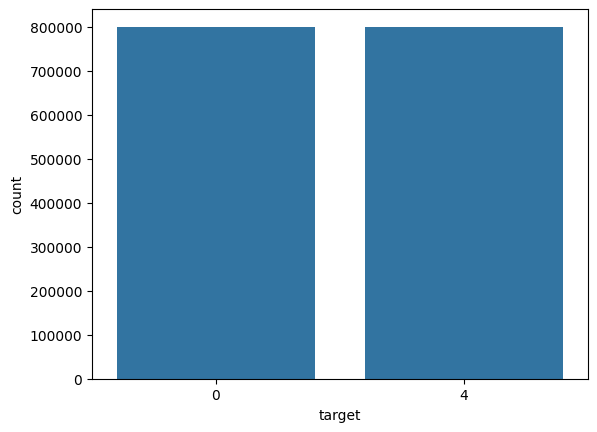

In [ ]:
sns.countplot(df, x='target')

Wyświetl kilka losowych przykładów z każdej klasy:

In [ ]:
df.loc[df['target'] == 4].sample(5)

,target,ids,date,flag,user,text
898753,4,1693677405,Sun May 03 23:22:14 PDT 2009,NO_QUERY,joshrlarsen,@astridlorange I like intimate viscosities lik...
895128,4,1692565801,Sun May 03 20:16:29 PDT 2009,NO_QUERY,themainex0x0,@mikevegasbaby i love the maine
840265,4,1559677861,Sun Apr 19 11:46:04 PDT 2009,NO_QUERY,htoddcarter,@chisaikame I love it when people talk about d...
1344230,4,2039855136,Thu Jun 04 22:59:00 PDT 2009,NO_QUERY,CEOAshford,Loves Coldplay Listening to them now
1040768,4,1956991942,Thu May 28 23:13:10 PDT 2009,NO_QUERY,HLNC,My Follow Friday Pick of the Week: @Shaaaane -...


In [ ]:
df.loc[df['target'] == 0].sample(5)

,target,ids,date,flag,user,text
138886,0,1880671739,Fri May 22 02:04:43 PDT 2009,NO_QUERY,CAM3L,Yay!! another Bank Holiday weekend approaching...
347036,0,2016339149,Wed Jun 03 06:36:13 PDT 2009,NO_QUERY,xxxbumblebee,is super gutted she cant even do her hair caus...
289402,0,1994997940,Mon Jun 01 12:47:21 PDT 2009,NO_QUERY,Kazcita,Childishly made a daisy chain in the park. A t...
190856,0,1969450207,Sat May 30 00:04:31 PDT 2009,NO_QUERY,dinibeanie,@cheeseyy aww cheese! that sucks but you can ...
587538,0,2216354260,Wed Jun 17 19:22:20 PDT 2009,NO_QUERY,JesusNeedsNewPR,@EliasJude's first fear http://jessicaturners...


# Preprocessing

Teraz jak wiemy z czym mamy do czynienia, zacznijmy od czyszczenia danych. Po pierwsze, skopiuj do nowej tabelki tylko kolumny `text` i `target`, a w kolumnie `target` zmień wartość 4 na 1. Można to zrobić metodą `replace` z parameterem `inplace` ustawionym na `True`.

In [ ]:
data = df.copy()
data = data[['target', 'text']]

In [ ]:
data['target'].replace(4, 1, inplace=True)

In [ ]:
data.sample(5)

,target,text
320405,0,@gavgavwaters me too shes following me and i a...
250742,0,wonderful weekend off spend studying
1122933,1,"@glasswentsmash canon , 12mpx , x3 zoom .opt.,..."
1197748,1,@c2s that's alright I'll stick to my favorite...
454644,0,Getting very very frustrated ;)


Teraz zamień wszystkie teksty w kolumnie `text` na małe litery (metodą `str.lower()`). Użyj do tego metody `apply` na kolumnie `text`. Niestety metoda ta nie posiada atrybutu `inplace` więc należy ręcznie nadpisać kolumnę nowymi wartościami.

In [ ]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.sample(5)

,target,text
1512658,1,likes evdo signal @ cikarang
860192,1,"1 paper, 1 midterm, 1 quiz, and 1 presentation..."
230434,0,@johart i'm exhausted just thinking about the ...
1276074,1,@simonyun yeah it was definitely not ideal.. i...
1436134,1,sun burnt....its hot and it hurts ....aloe ver...


Teraz użyj biblioteki [re](https://docs.python.org/3/library/re.html) żeby usunąć z tekstu wszystkie URLe - np. wszystkie tokeny oddzielone spacją zaczynające się od `www.` albo `http(s)://`.

In [ ]:
def remove(text):
    data = r'\b(?:https?://|www\.)\S+\b'
    return re.sub(data, '', text)

data['text'] = data['text'].apply(remove)

Teraz usuń wyrażeniami regularnymi wszystkie znaki z tekstu oprócz:
* liter alfabetu
* białych znaków (klasa `\s`)
* apostrofu `'` (chodzi o angielskie skracanie, np don't albo isn't)

In [ ]:
def clean(text):
    data = r"[^a-zA-Z\s']"
    return re.sub(data, '', text)

data['text'] = data['text'].apply(clean)

In [ ]:
data.sample(5)

,target,text
345109,0,sos so broke and need so much money
939064,1,tjinkerson we've been doing them together for ...
1466835,1,abigailrieley crap
1285672,1,brain fart i swear i read that appointment ti...
1429481,1,jradoff wrong seb but thanks none the less


Następnie wczytamy model `en_core_web_md` z biblioteki spacy. Użyjemy do tego metody `spacy.load`, ale dodamy też atrybut `disable=['ner', 'parser']`. W następnej linii dopiszemy `nlp.add_pipe('sentencizer')`.

Usunięcie zbędnych pipelineów przyspieszy proces lematyzacji opisywany niżej.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md", disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Zanim się weźmiemy za lematyzację, usuniemy z tekstu wszystkie tzw. "stop words", czyli słowa o małej przydatności w procesie klasyfikacji.

Obejrzyj listę słów `nlp.Defaults.stop_words`.

In [ ]:
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'regarding', "'re", 'be', 'may', 'back', 'less', 'nevertheless', '’re', 'four', 'therein', 'to', 'a', 'after', 'hers', 'your', 'ever', 'out', 'n‘t', 'moreover', 'for', 'becomes', 'latterly', 'me', 'within', 'towards', 'before', 'who', 'beforehand', 'put', 'ourselves', 'take', "n't", 'just', 'ten', 'which', 'one', 'wherever', 'further', 'indeed', 'go', 'has', 'over', 'hundred', 'doing', 'make', 'three', 'or', 'mine', 'whereupon', 'cannot', 'we', 'them', 'did', 'call', 'not', '’m', 'thence', 'mostly', 'been', 'except', 'still', 'across', 'him', '’ll', 'various', "'d", '‘s', 're', 'whither', 'now', 'those', 'therefore', 'front', "'s", 'please', 'the', 'whether', 'quite', 'side', 'anyhow', 'should', 'although', 'above', 'become', 'once', 'any', 'whom', '‘ll', 'can', 'already', 'else', 'ca', 'everyone', 'sometimes', 'through', 'you', 'into', 'why', 'often', 'few', 'show', 'wherein', 'neither', 'seeming', 'ours', 'only', 'empty', 'everywhere', 'even', 'is', 'thereafter', 'serious', 'whereby

Teraz zrób funkcję do usuwania stopwords która bierze tekst i zwraca tekst z usuniętymi słowami z listy powyżej. Użyj metody `apply` do zastosowania tej funkcji na całym zbiorze danych - tak jak to robiliśmy dotąd.

In [ ]:
def remove_stop_words(text):
    doc = nlp(text)
    text = " ".join([token.text for token in doc if not token.is_stop])
    return text

Następny krok jest zbyt czasochłonny żeby go zastosować na lekcji na całym zbiorze danych. Wczytaj zatem 20 tysięcy próbek (po 10 tys. na klasę) do nowej tabelki:

In [ ]:
data_class_0 = data[data['target'] == 0].sample(n=10000, random_state=42)
data_class_1 = data[data['target'] == 1].sample(n=10000, random_state=42)

data_new = pd.concat([data_class_0, data_class_1])

data_new = data_new.sample(frac=1, random_state=42).reset_index(drop=True)

data_new.head()

,target,text
0,1,dawnrichard thanks luvkeep the grind going lik...
1,0,i feel like watching the life aquatic but i do...
2,0,so aparentally early this morning erol died of...
3,0,chopchop get dressed getting ready for work
4,1,misshaleymae you know it baby x


Tokenizacja i lematyzacja w bibliotece spacy jest dosyć prostym procesem. Wystarczy przekazać tekst do modułu `nlp` czyli napisać `nlp(text)`. Zwróci nam to generator którego możemy przeiterować metodą `for` i dla każdego elementu (każdego wyrazu) zwrócić parametr `lemma_` (z podkreślikiem, żeby otrzymać string zamiast indeksu). Wszystkie lematy oczywiście należy połączyć spacjami z powrotem w tekst.

Użyj do tego metody `progress_apply` tak samo jako `apply` użyty powyżej.

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

data_new['lemmatized_text'] = data_new['text'].progress_apply(lemmatize_text)

100%|██████████| 20000/20000 [01:18<00:00, 253.82it/s]


## Chmury słów

Jak mamy oczyszczony tekst, możemy zwizualizować jego zawartość sprawdzając chmury słów. Użyjemy do tego biblioteki `WordCloud`. Do konstruktora podaj atrybuty `max_words = 1000`, `width = 1600`, `height = 800`, `collocations=False`, a potem użyj metody `generate` podając do niej tekst złączony z całego przelematyzowanego zbioru. Na koniec użyj metody `to_image()` żeby wyświetlić chmurę.

Zrób to osobno dla klasy negatywnej i pozytywnej. Jakie słowa tam widzisz? Czy są jakieś słowa które się pojawiają w obydwu klasach (może powinny trafić na listę stop-words)?

Chmura słów dla negatywnej:


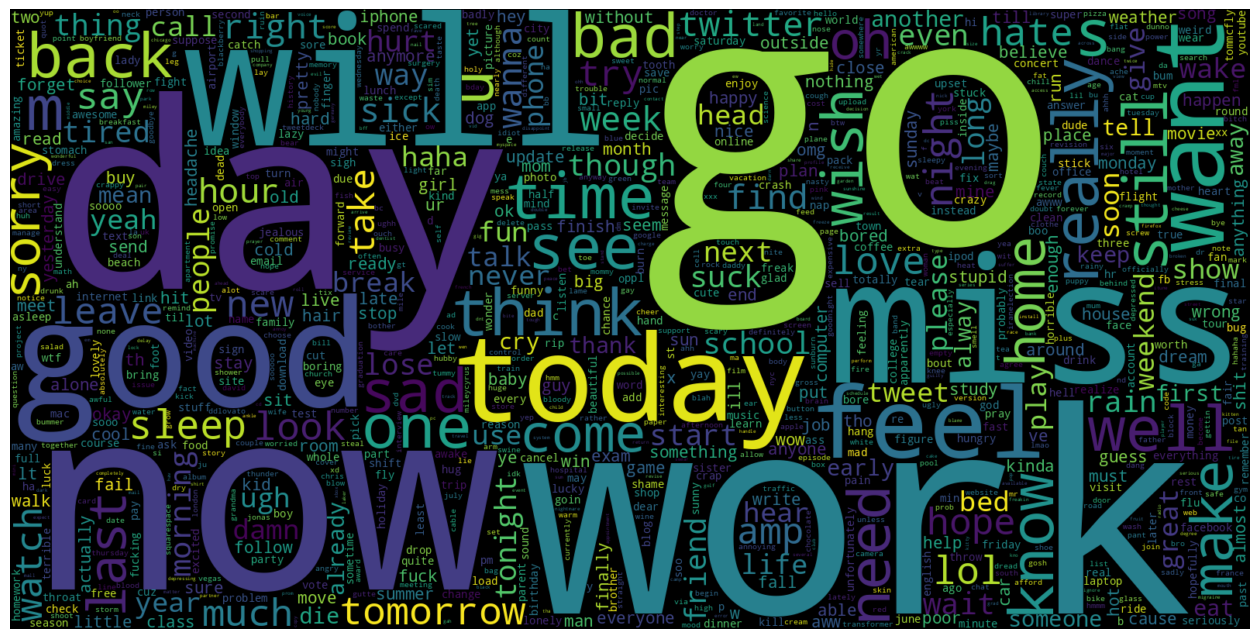

Chmura słów dla pozytywnej:


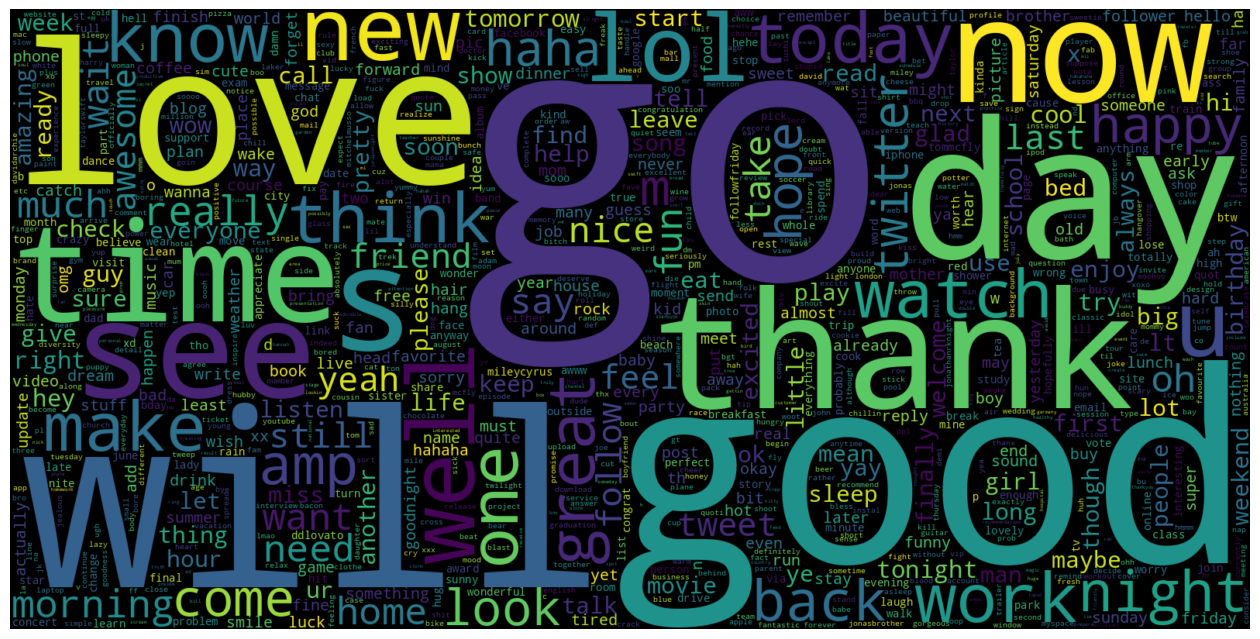

In [ ]:
data_new_0 = ' '.join(data_new[data_new['target'] == 0]['lemmatized_text'])
data_new_1 = ' '.join(data_new[data_new['target'] == 1]['lemmatized_text'])

def wordcloud(text):
    wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
    plt.figure(figsize=(16,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

print("Chmura słów dla negatywnej:")
wordcloud(data_new_0)

print("Chmura słów dla pozytywnej:")
wordcloud(data_new_1)

# Klasyfikacja

Podziel zbiór standardową metodą `train_test_split`: 10% test, 90% train. Użyj też stratyfikacji!

In [ ]:
X = data_new['lemmatized_text']
y = data_new['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

Teraz musimy wyciągnąć jakieś sensowne cechy z każdego elementu. Użyjemy do tego klasę `TfidfVectorizer`. Dodamy do konstruktora atrybut `max_features=500000` oraz `ngram_range=(1,2)` żeby wskazać że szukamy par wyrazów, a nie tylko unigramów.

Potem zastosuj metodę `fit` na zbiorze `X_train`.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

Klasa ta najpierw szuka listy wyrazów (a raczej par) mających wysoką wartość według kryterium TF-IDF. Użyj metody `get_feature_names_out` żeby pobrać ich listę. Ile jest tych elementów?

In [ ]:
features = tfidf_vectorizer.get_feature_names_out()
number_of_features = len(features)
print(number_of_features)

130730


Teraz zastosuj metodę `transform` na zbiorach `X_train` i `X_test`.

In [ ]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Jakie są rozmiary powstałych tablic?

Na szczęście, scikit-learn je zapisał automatycznie w formacie "sparse matrix" więc nie zajmują tak dużo pamięci.

In [ ]:
print(X_train_tfidf.shape, X_test_tfidf.shape)

(18000, 130730) (2000, 130730)


Wypisz tablekę `X_train` metodą `print` żeby zobaczyć fragment jej zawartości.

Zobaczymy w ten sposób tylko wartości różne od 0.

In [ ]:
print(X_train_tfidf)

  (0, 92273)	0.3451987626230726
  (0, 92257)	0.24971676740353618
  (0, 76314)	0.30626063471719905
  (0, 76130)	0.1032939920354119
  (0, 63355)	0.2414995960786849
  (0, 63302)	0.18293410369307495
  (0, 61608)	0.3451987626230726
  (0, 61489)	0.15568796304152668
  (0, 39444)	0.33129004595000366
  (0, 39431)	0.19814215977547908
  (0, 37029)	0.11865720513436792
  (0, 32120)	0.3940508770858923
  (0, 32096)	0.24560818174111057
  (0, 17721)	0.2847324460238182
  (0, 17541)	0.1380625785467189
  (1, 129475)	0.2009838759952433
  (1, 129258)	0.24096728469977693
  (1, 129086)	0.14240949964690336
  (1, 124123)	0.16533194394064532
  (1, 123990)	0.11790761953244755
  (1, 103250)	0.2510402903172461
  (1, 103224)	0.1620146117186666
  (1, 99211)	0.16533194394064532
  (1, 98878)	0.08530211295656177
  (1, 92903)	0.12381924704439524
  :	:
  (17998, 24058)	0.2019377356568259
  (17998, 24038)	0.15079035040028763
  (17998, 23353)	0.2103792132963509
  (17998, 23351)	0.16986683212397835
  (17998, 20977)	0.1959484

## Właściwa klasyfikacja

Stwórz model `BernoulliNB`, czyli Naive Bayes - popularny do klayfikacji spamu! Użyj metody `fit` na danych traningowych, `predict` na testowych i `classification_report` żeby sprawdzić wynik.

Jeśli masz ochotę narysuj tez macierz konfuzji i wypróbuj inne klasyfikatory oraz metody ekstrakcji cech z biblioteki scikit-learn.

In [ ]:
clf = BernoulliNB()

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1000
           1       0.76      0.76      0.76      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000

